In [1]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
import matplotlib.pyplot as plt
from shapely import wkt
from shapely.geometry import box

In [2]:
# Read OBIS occurence data into dataframe
raw_df = pd.read_csv('data\OBIS_anemone_occurrences_slim.tsv', sep='\t')
raw_df['geometry'] = raw_df['geometry'].apply(wkt.loads)
raw_gdf = gpd.GeoDataFrame(raw_df, geometry='geometry', crs=4326)

# Transform occurence data to Behrmann projection
behrmann_occurences_gdf = raw_gdf.to_crs("ESRI:54017")

In [3]:
# Read GBIF occurence data into dataframe
raw_df = pd.read_csv('data\GBIF_species_ID_complete.csv')

In [4]:
## DATA CLEANING & PREPROCESSING
# Remove null coordinates
raw_df = raw_df.dropna(subset=['decimalLongitude', 'decimalLatitude'])

# Remove points at origin (coordinate 0, 0)
raw_df = raw_df[(raw_df[['decimalLongitude','decimalLatitude']] != 0).all(axis=1)]

In [5]:
# Read into geodataframe
raw_gdf = gpd.GeoDataFrame(
    raw_df, 
    geometry=gpd.points_from_xy(raw_df['decimalLongitude'], raw_df['decimalLatitude']),
    crs='EPSG:4326'
)

# Transform to Behrmann projection
behrmann_raw_gdf = raw_gdf.to_crs('ESRI:54017')

In [6]:
# Read Natural Lands ocean map
ocean_gdf = gpd.read_file('data\\ne_10m_ocean.shp', crs='ESRI:4326')

# Transform to Behrmann projection
ocean_gdf = ocean_gdf.to_crs('ESRI:54017')

# Remove occurence points 10km or more inland
ocean_10km_buffer = ocean_gdf.buffer(10000)
occurences_gdf = behrmann_raw_gdf.clip(ocean_10km_buffer)


In [16]:
from math import ceil

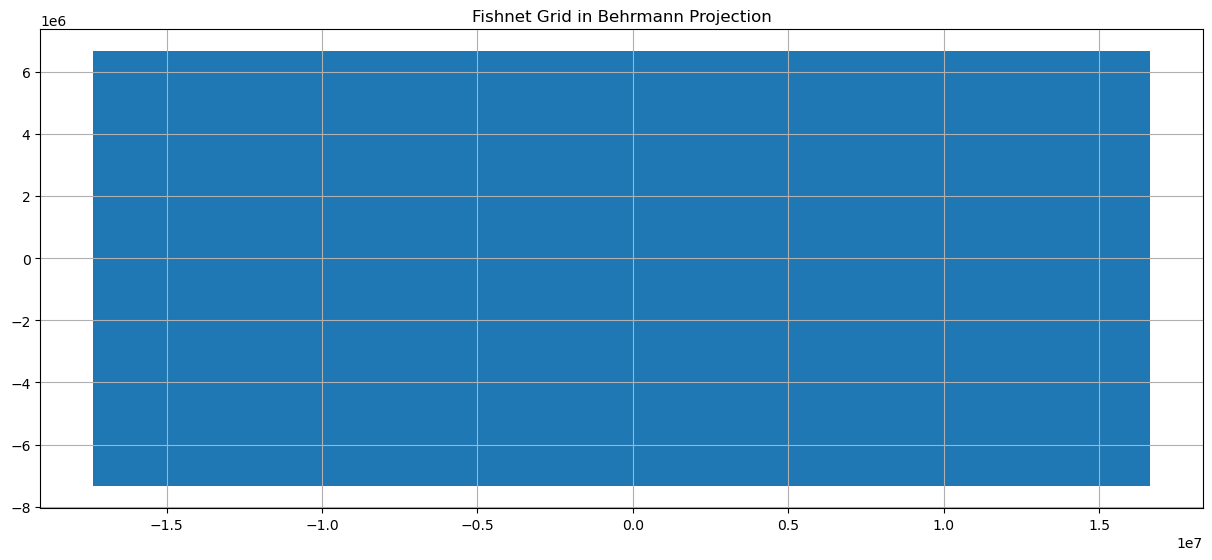

In [19]:
def create_fishnet(grid_size, bbox, projection):
    # Initialize the transformer to convert from geographic (longitude, latitude) to Behrmann projection
    transformer = Transformer.from_crs("EPSG:4326", projection, always_xy=True)
    
    # Transform the bounding box coordinates to the projection
    min_x, min_y = transformer.transform(bbox[0], bbox[1])
    max_x, max_y = transformer.transform(bbox[2], bbox[3])
    
    # Calculate number of cells needed in the x and y directions
    x_cells = ceil(int((max_x - min_x) / grid_size))
    y_cells = ceil(int((max_y - min_y) / grid_size))
    
    # Generate polygons for each cell in the grid
    polygons = []
    for i in range(x_cells):
        for j in range(y_cells):
            # Coordinates of the lower left corner of the grid cell
            x1 = min_x + i * grid_size
            y1 = min_y + j * grid_size
            # Create a polygon for the grid cell
            poly = box(x1, y1, x1 + grid_size, y1 + grid_size)
            polygons.append(poly)
    
    # Create a GeoDataFrame from the polygons
    grid = gpd.GeoDataFrame({'geometry': polygons}, crs=projection)
    return grid

# Define bounding box in geographic coordinates [min_lon, min_lat, max_lon, max_lat]
bbox = [-180, -90, 180, 90]  # Adjust latitude as per the usability in cylindrical projections

# Grid size in meters (e.g., 1000 km)
grid_size = 1000000

# Create the fishnet grid
grid = create_fishnet(grid_size, bbox, behrmann_proj)

# Plot the grid
fig, ax = plt.subplots(figsize=(15, 8))
grid.plot(ax=ax)
plt.title('Fishnet Grid in Behrmann Projection')
plt.grid(True)
plt.show()


In [20]:
grid.to_file("behrmann_grid.shp", crs="ESRI:54017")